In [100]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input
import matplotlib.pyplot as plt

In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE  
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
for image_batch, label_batch in dataset.take(1):      #will take the 1 batch of 32 size from the multiple batches in dataset
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]


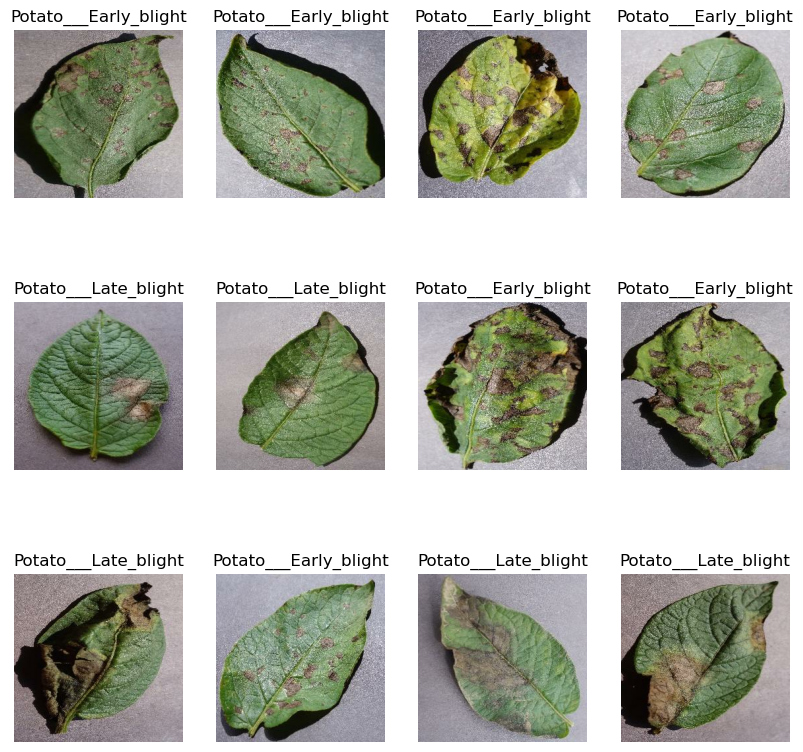

In [34]:
plt.figure(figsize=(10,10 ))
for image_batch, label_batch in dataset.take(1):      #will take the 1 batch of 32 size from the multiple batches in dataset
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #values will be in float so converted to integer
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

In [36]:
'''
80% data to train the model
10% data for validation, it will be used after each epoch to validate
20% data for test the model
'''

'\n80% data to train the model\n10% data for validation, it will be used after each epoch to validate\n20% data for test the model\n'

In [40]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [44]:
#so we have to take 54 dataset sample, takes first 54 batches
train_ds = dataset.take(54)
len(train_ds)

54

In [48]:
#skips first 54 data set
test_ds = dataset.skip(54)
len(test_ds)

14

In [54]:
#for validation
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [58]:
validation_ds = test_ds.take(6)
len(validation_ds)

6

In [60]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [74]:
#all the above can be done using the funcation
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_len = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_len)
    val_size = int(val_split*ds_len)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(len(train_ds)).take(val_size)
    test_ds = dataset.skip(len(train_ds)).skip(val_size)
    return train_ds, val_ds, test_ds

In [76]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [78]:
len(test_ds)

8

In [90]:
#cache - read the img from disk and keep it in memory(RAM) for next iteration
#prefetch - CPU loads the next batch while GPU is training on the previous batch

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [92]:
#rescaling typically involves normalizing pixel values, which are usually in the range [0, 255] (for 8-bit images), 
#to a smaller range, such as [0, 1] or [-1, 1].

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [94]:
#data augmentation for the images to improve accuracy

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [106]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),     #3 classes as we have 3 outputs and softmax as it normalizes the probability
])

model.build(input_shape=input_shape)

C:\Users\Apurva\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [118]:
histroy = model.fit(
    train_ds, 
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,                    #how much info to show while training (=====> or the loss: accuracy:)
    validation_data=validation_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 957ms/step - accuracy: 0.6926 - loss: 0.6567 - val_accuracy: 0.8385 - val_loss: 0.3491
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 942ms/step - accuracy: 0.8524 - loss: 0.3582 - val_accuracy: 0.8229 - val_loss: 0.4300
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 937ms/step - accuracy: 0.8998 - loss: 0.2638 - val_accuracy: 0.7760 - val_loss: 0.5592
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 950ms/step - accuracy: 0.9043 - loss: 0.2583 - val_accuracy: 0.9219 - val_loss: 0.1552
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 966ms/step - accuracy: 0.9431 - loss: 0.1594 - val_accuracy: 0.9479 - val_loss: 0.1343
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 966ms/step - accuracy: 0.9437 - loss: 0.1440 - val_accuracy: 0.9271 - val_loss: 0.2015
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 964ms/step - accuracy: 0.9315 - loss: 0.2127 - val_accuracy: 0.9271 - val_loss: 0.2833
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 967ms/step - accuracy: 0.9499 - loss: 0.1224 - val_accu

In [120]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9903 - loss: 0.0381


In [122]:
score

[0.03056309185922146, 0.9913793206214905]

In [124]:
histroy.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [126]:
histroy.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [134]:
histroy.history['accuracy'][:5]

[0.7442129850387573,
 0.8559027910232544,
 0.9091435074806213,
 0.8975694179534912,
 0.9502314925193787]

In [136]:
acc = histroy.history['accuracy']
loss = histroy.history['loss']
val_acc = histroy.history['val_accuracy']
val_loss = histroy.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

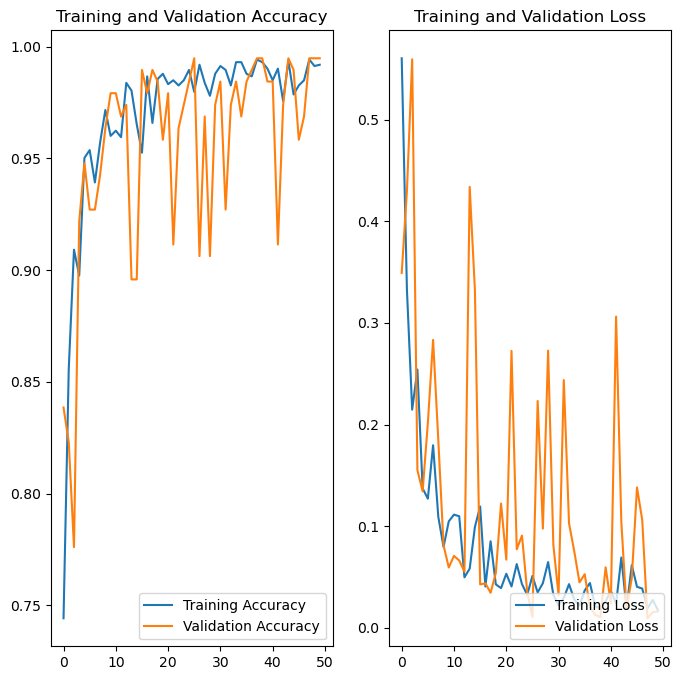

In [140]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Predicted Label:  Potato___Early_blight


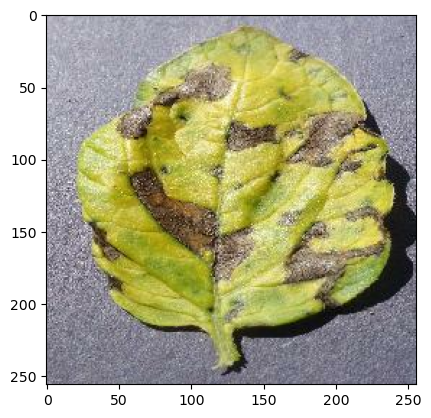

In [148]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print('Actual Label: ', class_names[first_label])


    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ', class_names[np.argmax(batch_prediction[0])])

In [158]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0)   #Creates a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


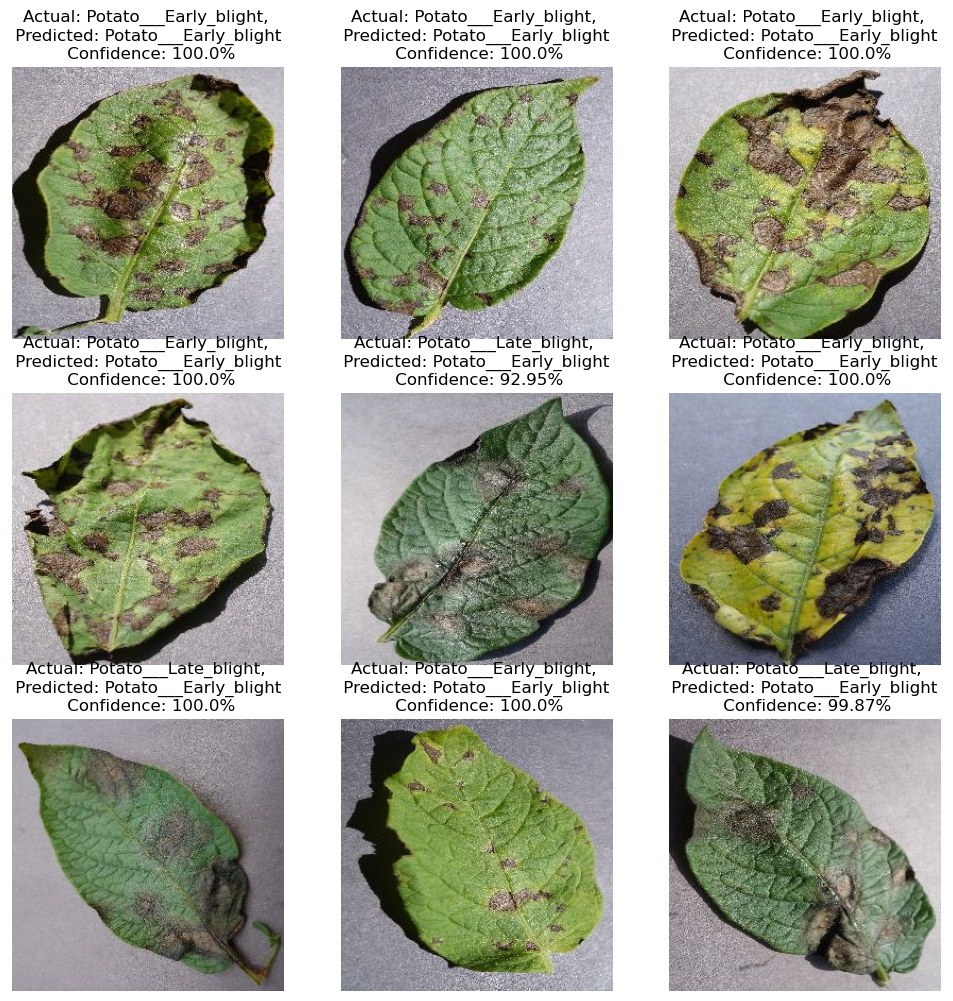

In [164]:
plt.figure(figsize=(12, 12))
for image, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, image[i].numpy())
        actual_class = class_names[label[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%')

        plt.axis('off')

In [180]:
model_version = 1
model.save(f"../models/v0.{model_version}.h5")

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
# from tensorflow import keras
# import tensorflow as tf

# # Load the model
# model = keras.models.load_model(r"C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models\1\v0.1.h5")

# # Save the model in the SavedModel format
# tf.saved_model.save(model, r"C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models\1")

from tensorflow.keras.models import load_model

# Load your .h5 model
h5_model_path = r"C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models\1\v0.1.h5"
model = load_model(h5_model_path)

In [10]:
saved_model_path = r"C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models"
model.export(saved_model_path)

INFO:tensorflow:Assets written to: C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models\assets


INFO:tensorflow:Assets written to: C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models\assets


Saved artifact at 'C:\Users\Apurva\Desktop\Projects\potato_disease_classification\saved_models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2215114625040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114625616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114627536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114628880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114628688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114627152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114627344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114629840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114628496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2215114630416: TensorSpec(shape=(), dtype=